In [1]:
%reset -f
import numpy as np
import pandas as pd
import random
import math
import os
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
mat = scipy.io.loadmat('NASAtrain_ICA_part.mat') #reads dataset
#mat = scipy.io.loadmat('NASAtrain_I.mat') #reads dataset for I segments
cellsName = [keys for keys in mat.keys() if not keys.startswith('__')]
numCell = len(cellsName)
print("mat structure:", numCell)
print("Name of cells:", cellsName)

mat structure: 4
Name of cells: ['train1', 'train2', 'train3', 'train4']


# Dataload design

In [4]:
# Extract data from matalab to list in python
Sequences = []
Labels = []
Length_ICA = []
windows = 10

for i in range(numCell):
    mat[cellsName[i]][0][0].dtype.names
    mat[cellsName[i]][0][0]['data'][0][0].shape
    numCycle = len(mat[cellsName[i]][0][0]['data'])
    numCycle

    ICA = [[] for _ in range(numCycle)]
    label = [[] for _ in range(numCycle)]
    length = [[] for _ in range(numCycle)]
    Sequences_temp = [[] for _ in range(numCycle-windows)]
    Labels_temp = [[] for _ in range(numCycle-windows)]

    for j in range(numCycle):
      ICA[j] =  torch.tensor(mat[cellsName[i]][0][0]['data'][j][0]).float() # list contain tensor sequences
      label[j] = torch.tensor(mat[cellsName[i]][0][0]['label'][j][0]).float()
      length[j] = len(mat[cellsName[i]][0][0]['data'][j][0][0])

    for j in range(windows, numCycle):
      Sequences_temp[j - windows] = ICA[j - windows:j]
      Labels_temp[j - windows] = label[j - windows:j] #collect all labels
      #Labels_temp[j - windows] = label[j] # Only labels for final cycle

    Length_ICA.extend(length)
    Sequences.extend(Sequences_temp)
    Labels.extend(Labels_temp)
# The dataset include the packed datas(size = windows) in format of list
# All datas are already the tensor format
print(f"size of ICA curves: {len(Length_ICA)}")
print(f"size of DataSequences(s): {len(Sequences)}")
print("----------------------------------------------------")
print(f"Typical element of Dataset: {len(Sequences[1])}")
for i in range(len(Sequences[1])):
  print(Sequences[0][i].shape)

print(f"Example labels: \n {Labels[1]}")

size of ICA curves: 636
size of DataSequences(s): 596
----------------------------------------------------
Typical element of Dataset: 10
torch.Size([3, 55])
torch.Size([3, 57])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 56])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 58])
Example labels: 
 [tensor(0.9946), tensor(0.9886), tensor(0.9886), tensor(0.9883), tensor(0.9888), tensor(0.9885), tensor(0.9835), tensor(0.9830), tensor(0.9828), tensor(0.9828)]


torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 60])
torch.Size([3, 58])
torch.Size([3, 57])
torch.Size([3, 55])
torch.Size([3, 56])
torch.Size([3, 56])
torch.Size([3, 56])


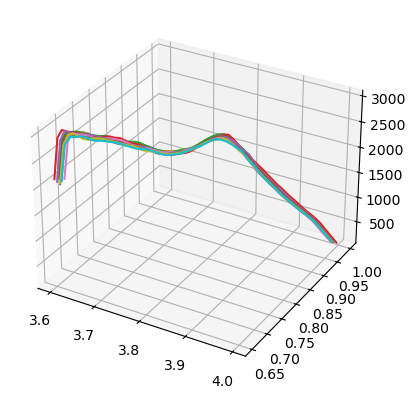

In [5]:
ax = plt.figure().add_subplot(projection='3d')
n = 100
for i in range(len(Sequences[1])):
  print(Sequences[n][i].shape)
  ax.plot(np.array(Sequences[n][i][0]), np.array(Sequences[n][i][1]), np.array(Sequences[n][i][2]), label='ICA')  

In [6]:
# Pack to dataset useing customised class
class MultiSequenceDataset(Dataset):
  # Here each returen will be a list of sequences and corresponding label
  # Demo like: Sequences, Labels = dataset[i]
    def __init__(self, data_points, targets):
        self.data_points = data_points
        self.targets = targets

    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx], self.targets[idx]

    def total_sequences(self):
        return sum(len(sequences) for sequences in self.data_points)

dataset = MultiSequenceDataset(Sequences, Labels)
# Get the number of top-level data points in the dataset
print("Number of top-level data points in the dataset:", len(dataset))

# Get the total number of sequences in the dataset
print("Total number of sequences in the dataset:", dataset.total_sequences())

def collate_fn(batch):
    data_points, targets = zip(*batch)
    return data_points, torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)

def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

Number of top-level data points in the dataset: 596
Total number of sequences in the dataset: 5960


In [7]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=512, collate_fn=collate_fn)

print(f"batch num of train_loader: {len(train_loader)} \nbatch num of test_loader: {len(test_loader)}")
print("--------------------------------------------------")
X_batch, T_batch= next(iter(test_loader))
print("Example size of dataloader display:")
for i in range(len(X_batch)):
    print(f"Sequences: {i+1}: \t Seqs in datapoint: {len(X_batch[i])} \t{X_batch[i][0].shape} \n Targets: {T_batch[i]}" )

batch num of train_loader: 1 
batch num of test_loader: 1
--------------------------------------------------
Example size of dataloader display:
Sequences: 1: 	 Seqs in datapoint: 10 	torch.Size([3, 45]) 
 Targets: tensor([0.6301, 0.6301, 0.6276, 0.6225, 0.6198, 0.6200, 0.6200, 0.6149, 0.6175,
        0.6353])
Sequences: 2: 	 Seqs in datapoint: 10 	torch.Size([3, 67]) 
 Targets: tensor([1.0000, 0.9937, 0.9919, 0.9872, 0.9883, 0.9861, 0.9792, 0.9761, 0.9732,
        0.9834])
Sequences: 3: 	 Seqs in datapoint: 10 	torch.Size([3, 59]) 
 Targets: tensor([0.9835, 0.9831, 0.9833, 0.9771, 0.9775, 0.9771, 0.9711, 0.9718, 0.9961,
        0.9848])
Sequences: 4: 	 Seqs in datapoint: 10 	torch.Size([3, 57]) 
 Targets: tensor([0.9018, 0.9131, 0.9421, 0.9213, 0.9107, 0.9029, 0.8928, 0.8904, 0.8824,
        0.8745])
Sequences: 5: 	 Seqs in datapoint: 10 	torch.Size([3, 61]) 
 Targets: tensor([0.8545, 0.8510, 0.8460, 0.8380, 0.8333, 0.8290, 0.8287, 0.8202, 0.8154,
        0.8126])
Sequences: 6: 	 Seqs

# Model define

In [9]:
X_batch[i][5].shape

torch.Size([3, 56])

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class CNN_LSTM_position(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM_position, self).__init__()
        # Single CNN layer
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.positional_encoding = PositionalEncoding(32)
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        # Apply the single CNN layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)

        # Apply self-attention
        x = x.transpose(0, 1)  # Convert to (seq_length, batch, channels)      
        x, attn_weights = self.self_attention(x, x, x)
        x = x.transpose(0, 1)  # Convert to (batch, seq_length, channels)

        # Add positional encoding
        x = self.positional_encoding(x)              
        # Select top features based on attention weights
        attn_weights = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights.topk(32, dim=1, largest=True).indices  # Top 32 features
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x = x[batch_indices, topk_indices]      
        
        x = self.relu(x)
        x = x.reshape(x.size(0), -1, 32)  # (batch, new_seq_length, channels)
        
        # Directly pass the sequence to LSTM
        x, (hn, cn) = self.lstm(x)
        
        x = self.fc1(hn[-1])
        x = self.relu(x)
        x = self.fc2(x)
        return x

class LSTMMultiCyclesRegressor(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(LSTMMultiCyclesRegressor, self).__init__()
        # HF extraction layer via CNN-Att-LSTM
        self.HFextract = CNN_LSTM_position(num_channels, num_heads, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units * 2, 9)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(9, 1)

    def forward(self, x):
        batch_size = len(x)
        processed_sequences = []

        for sequences in x:
            HFs = [] # Store the out pput from HF selection layer 
            seqtensor = [tensor[:, :] for tensor in sequences]         
            sequences = torch.stack(seqtensor)        
            HFs = self.HFextract(sequences)
            #print(HFs.shape)
            processed_sequences.append(HFs)
            # This code processes 15 and outputs 15 HFs, parallelly

        processed_sequences = torch.stack(processed_sequences)  # Convert to [batch_size, num_sequences, HF_features]
        #print(processed_sequences.shape)
        output = processed_sequences
        # Here the stack is stack the batch
        return output
# Example usage

model = LSTMMultiCyclesRegressor(num_channels=3, num_heads=4, num_hidden_units=128)

In [11]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = LSTMMultiCyclesRegressor(num_channels=3, num_heads=4, num_hidden_units=128)
model = model.to(device)

# Training parameters
num_epochs = 200

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


# RMSE Loss Function
def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Lists to store losses
train_losses = []
test_losses = []

# Variable to store the best model and the lowest loss
best_model_state = None
lowest_train_loss = float('inf')

# Training and testing loop with inspection
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # evey loop a batch [batch_size, sequences_num, data(3, length_num)]
        print(f"Before Batch {batch_idx} - Input shape:{type(inputs)} {len(inputs)}, {len(inputs[0])}, {inputs[0][0].shape} - targets shape: {len(targets)}")
        targets = targets.to(device)
        inputs = torch.stack(inputs, dim=0).to(device)
        print(f"After Batch {batch_idx} - Input shape: {len(inputs)}, {len(inputs[0])}, {inputs[0][0].shape} - targets shape: {len(targets)}")
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = rmse_loss(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    

    # Save the best model based on training loss
    if train_loss < lowest_train_loss:
        lowest_train_loss = train_loss
        best_model_state = model.state_dict()

    # Test the model after each epoch
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = [[seq.to(device) for seq in sequence] for sequence in inputs]
            targets = targets.to(device)
            outputs = model(inputs)
            loss = rmse_loss(outputs.squeeze(), targets)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Loss display
    if (epoch+1)%20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}")

    # Adjust the learning rate based on the validation loss
    #scheduler.step(test_loss)

# Save the best model to a file
torch.save(best_model_state, 'best_model.pth')

# Plot the losses using RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training RMSE')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Test RMSE')
plt.show()


Using device: cuda
Before Batch 0 - Input shape:<class 'tuple'> 476, 10, torch.Size([3, 72]) - targets shape: 476


TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
from torchview import draw_graph
numChannels = 3
numHeads = 4
numHiddenUnits = 128
num_epochs = 200
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =LSTMMultiCyclesRegressor(num_channels=3, num_heads=4, num_hidden_units=128).to(device)
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(1,5,3,50), device='cuda')
model_graph.visual_graph